# Traning - Features

In [55]:
%pip install -r ../requirements.txt

You should consider upgrading via the '/home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [56]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['ABSL_LOG_THRESHOLD'] = '0'

# Built-in
import ast
import json
from functools import partial
from pathlib import Path

# Third-party - Data Handling
import numpy as np
import pandas as pd

# Third-party - Visualization
import matplotlib.pyplot as plt

# Third-party - Machine Learning
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Third-party - Deep Learning
import keras
import tensorflow as tf
from tensorflow.keras import layers, models

# Third-party - Audio Processing
import librosa
from librosa.feature.rhythm import tempo
import soundfile as sf

# Third-party - Utilities
from tqdm import tqdm

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("Is TensorFlow using GPU?", tf.test.is_gpu_available())
print("GPU disponível:", tf.config.list_physical_devices('GPU'))
print("XLA ativado:", tf.config.optimizer.get_jit())
# Mostra configuração geral
tf.config.experimental.list_physical_devices()

TensorFlow: 2.19.0
Keras: 3.9.2
Is TensorFlow using GPU? True
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
XLA ativado: 


I0000 00:00:1745900549.038503   71551 gpu_device.cc:2019] Created device /device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:0a:00.0, compute capability: 7.5


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [57]:
ORIGIN_DATASET_PATH = '../datasets/augmented'
ORIGIN_DATASET_VERSION = 'v2'

ORIGIN_DATASET_VERSION_PATH = Path(os.path.join(ORIGIN_DATASET_PATH, ORIGIN_DATASET_VERSION))
ORIGIN_DATASET_TRAIN_METADATA = ORIGIN_DATASET_VERSION_PATH / 'train_metadata.csv'
ORIGIN_DATASET_TRAIN_DATA = ORIGIN_DATASET_VERSION_PATH / 'train_data'

ORIGIN_DATASET_TEST_METADATA = ORIGIN_DATASET_VERSION_PATH / 'test_metadata.csv'
ORIGIN_DATASET_TEST_DATA = ORIGIN_DATASET_VERSION_PATH / 'test_data'

In [58]:
TRAINING_DATASET_PATH = '../datasets/training'
TRAINING_DATASET_VERSION = 'v6'

TRAINING_DATASET_VERSION_PATH = Path(os.path.join(TRAINING_DATASET_PATH, TRAINING_DATASET_VERSION))

TRAINING_DATASET_TRAIN_METADATA = TRAINING_DATASET_VERSION_PATH / 'train_metadata.csv'
TRAINING_DATASET_TRAIN_DATA = TRAINING_DATASET_VERSION_PATH / 'train_data'
TRAINING_DATASET_TRAIN_DATA.mkdir(parents=True, exist_ok=True)

TRAINING_DATASET_TEST_METADATA = TRAINING_DATASET_VERSION_PATH / 'test_metadata.csv'

TRAINING_DATASET_VERSION_PATH.mkdir(parents=True, exist_ok=True)
print(f"📁 TRAINING_DATASET_VERSION_PATH: {TRAINING_DATASET_VERSION_PATH}")

📁 TRAINING_DATASET_VERSION_PATH: ../datasets/training/v6


In [59]:
def mean_pool(array, target_bins):
    current_bins = array.shape[0]

    if current_bins == target_bins:
        return array

    factor = current_bins // target_bins
    if factor < 1:
        # Se tem menos bins do que o desejado, fazer padding
        pad_width = target_bins - current_bins
        padding = np.zeros((pad_width, array.shape[1]))
        pooled = np.vstack([array, padding])
    else:
        # Agrupa e faz média
        pooled = array[:factor * target_bins]  # corta para múltiplo exato
        pooled = pooled.reshape(target_bins, factor, -1).mean(axis=1)

    return pooled


In [60]:
from scipy.signal import resample

def extract_features(row, basepath, n_mfcc=80, fixed_tempogram_bins=30):
    filepath = basepath / row['filename']
    y, sr = librosa.load(filepath, res_type='kaiser_fast')

    # 🎵 MFCC e Delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    combined = np.concatenate((mfcc, delta_mfcc), axis=0)

    # 🎵 Rhythm features
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

    tempo_value = tempo(onset_envelope=onset_env, sr=sr)
    tempo_value = np.repeat(tempo_value, combined.shape[1])[np.newaxis, :]

    frames = onset_env.shape[0]
    safe_win_length = min(64, frames)

    # 🎵 Tempogram
    tempogram = librosa.feature.tempogram(
        onset_envelope=onset_env,
        sr=sr,
        win_length=safe_win_length
    )

    # 🔥 Interpolação para bins fixos
    tempogram_resampled = resample(tempogram, fixed_tempogram_bins, axis=0)

    # 🎵 PLP seguro
    plp = librosa.beat.plp(y=y, sr=sr, win_length=safe_win_length)[np.newaxis, :]

    # 🔧 Ajustar todos para o mesmo número de frames
    min_frames = min(combined.shape[1], tempogram_resampled.shape[1], plp.shape[1])

    combined = combined[:, :min_frames]
    tempogram_resampled = tempogram_resampled[:, :min_frames]
    plp = plp[:, :min_frames]
    tempo_value = tempo_value[:, :min_frames]

    # 🔗 Concatenar tudo
    full_features = np.concatenate((combined, tempogram_resampled, plp, tempo_value), axis=0)

    # 🔄 Normalizar
    full_features = (full_features - np.mean(full_features)) / np.std(full_features)

    return full_features.T  # (frames, features)


In [61]:
# 📖 Carregar metadata completo
origin_train_df = pd.read_csv(ORIGIN_DATASET_TRAIN_METADATA)

# 🔥 Coletar número de features únicos (shape[1])
feature_dims = set()

# 🔥 Loop sobre várias amostras
for idx, row in origin_train_df.head(1000).iterrows():
    features = extract_features(row, ORIGIN_DATASET_TRAIN_DATA)
    feature_dims.add(features.shape[1])

# 📏 Mostrar dimensões únicas encontradas
print(f"📏 Número de features únicos encontrados: {feature_dims}")


KeyboardInterrupt: 

In [ ]:
def prepare_dataset(
    metadata_file,
    input_audio_dir,
    output_metadata,
    output_data,
    n_mfcc=80,
):
    """
    Extrai features dos áudios e salva:
    - Um .npz individual para cada amostra (features + label)
    - Um arquivo CSV de metadados referenciando os arquivos .npz
    """
    print(f"📖 Lendo metadados de: {metadata_file}")
    print(f"🎧 Lendo áudios de: {input_audio_dir}")

    metadata_file = Path(metadata_file)
    input_audio_dir = Path(input_audio_dir)
    output_metadata = Path(output_metadata)
    output_data = Path(output_data)

    output_data.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(metadata_file)
    df = df.sample(n=1000, random_state=42) 

    # Ajusta LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(df['class'])

    feature_extractor = partial(extract_features, basepath=input_audio_dir, n_mfcc=n_mfcc)

    meta_records = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Salvando .npz individuais"):
        features = feature_extractor(row)
        label = label_encoder.transform([row['class']])[0]

        sample_name = f"sample_{idx:06d}.npz"
        npz_path = output_data / sample_name

        # Salva um arquivo por amostra
        np.savez_compressed(npz_path, features=features, label=label)

        # Guarda registro para o CSV
        meta_records.append({
            "filename": sample_name,
            "class": row['class'],
            "label": int(label)
        })

    # Salva o CSV de metadados
    meta_df = pd.DataFrame(meta_records)
    output_metadata.parent.mkdir(parents=True, exist_ok=True)
    meta_df.to_csv(output_metadata, index=False)

    print(f"✅ Dataset salvo: {len(df)} amostras")
    print(f"📄 Metadados salvos em: {output_metadata}")
    print(f"📂 Features salvas em: {output_data}")

    return label_encoder


In [ ]:
label_encoder = prepare_dataset(
    metadata_file=ORIGIN_DATASET_TRAIN_METADATA,
    input_audio_dir=ORIGIN_DATASET_TRAIN_DATA,
    output_metadata=TRAINING_DATASET_TRAIN_METADATA,
    output_data=TRAINING_DATASET_TRAIN_DATA,
    n_mfcc=80
)

📖 Lendo metadados de: ../datasets/augmented/v2/train_metadata.csv
🎧 Lendo áudios de: ../datasets/augmented/v2/train_data


Salvando .npz individuais: 100%|██████████| 1000/1000 [02:35<00:00,  6.42it/s]

✅ Dataset salvo: 1000 amostras
📄 Metadados salvos em: ../datasets/training/v6/train_metadata.csv
📂 Features salvas em: ../datasets/training/v6/train_data


In [73]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

def create_train_val_datasets(meta_csv_path, data_folder_path, batch_size=32, val_split=0.2, shuffle=True):
    meta_df = pd.read_csv(meta_csv_path)
    data_folder_path = Path(data_folder_path)

    filepaths = meta_df['filename'].tolist()
    labels = meta_df['label'].tolist()

    # 🔥 Infere o número de features (dimensionalidade) dinamicamente
    sample_npz = np.load(data_folder_path / filepaths[0])
    features_dimensionality = sample_npz['features'].shape[1]

    print(f"✅ Features dimensionality inferida automaticamente: {features_dimensionality}")

    # Split usando sklearn
    train_files, val_files, train_labels, val_labels = train_test_split(
        filepaths,
        labels,
        test_size=val_split,
        random_state=42,
        stratify=labels
    )

    def process_path(filename, label):
        # Carrega o arquivo .npz no modo numpy puro
        npz = np.load(str(data_folder_path / filename.numpy().decode('utf-8')))
        features = npz['features'].astype(np.float32)
        return features, label

    def tf_process_path(filename, label):
        features, label = tf.py_function(
            func=process_path,
            inp=[filename, label],
            Tout=(tf.float32, tf.int32)
        )
        features.set_shape([None, features_dimensionality])  # frames variáveis, features fixos
        label.set_shape([])
        return features, label

    def make_dataset(filepaths, labels):
        ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

        if shuffle:
            ds = ds.shuffle(buffer_size=len(filepaths), reshuffle_each_iteration=True)

        ds = ds.map(tf_process_path, num_parallel_calls=tf.data.AUTOTUNE)

        ds = ds.padded_batch(
            batch_size,
            padded_shapes=(
                [None, features_dimensionality],
                []
            ),
            padding_values=(
                0.0,
                tf.cast(-1, tf.int32)
            )
        )

        ds = ds.prefetch(tf.data.AUTOTUNE)

        return ds

    train_dataset = make_dataset(train_files, train_labels)
    val_dataset = make_dataset(val_files, val_labels)

    return train_dataset, val_dataset


In [90]:
train_dataset, val_dataset = create_train_val_datasets(
    meta_csv_path=TRAINING_DATASET_TRAIN_METADATA,
    data_folder_path=TRAINING_DATASET_TRAIN_DATA,
    batch_size=100,
    val_split=0.2,
    shuffle=True
)

✅ Features dimensionality inferida automaticamente: 192


In [91]:
model = models.Sequential([
    layers.Input(shape=(None, 192), ragged=True),

    layers.Conv1D(128, kernel_size=5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling1D(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [92]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


2025-04-29 01:40:25.577227: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB (rounded to 1901918976)requested by op 
2025-04-29 01:40:25.577293: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-29 01:40:25.577303: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 499, Chunks in use: 499. 124.8KiB allocated for chunks. 124.8KiB in use in bin. 2.6KiB client-requested in use in bin.
2025-04-29 01:40:25.577307: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 108, Chunks in use: 108. 55.0KiB allocated for chunks. 55.0KiB in use in bin. 54.1KiB client-requested in use in bin.
2025-04-29 01:40:25.577310: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (1024): 	Total Chunks: 178, Chunks in use: 178. 178.2KiB allocated for chunks. 178.2KiB in use in bin. 177.6KiB client-

RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL ResourceExhaustedError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/framework/errors_impl.py(377): __init__
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/eager/context.py(1688): call_function
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(919): _call
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py(219): function
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py(371): fit
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py(117): error_handler
  /tmp/ipykernel_71551/3787797742.py(1): <module>
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3550): run_code
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3490): run_ast_nodes
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3308): run_cell_async
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3103): _run_cell
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3048): run_cell
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py(449): do_execute
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py(362): execute_request
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /home/rcalabro/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/events.py(80): _run
  /home/rcalabro/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/base_events.py(1905): _run_once
  /home/rcalabro/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/base_events.py(601): run_forever
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py(205): start
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py(739): start
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/ipykernel_launcher.py(18): <module>
  /home/rcalabro/.asdf/installs/python/3.9.16/lib/python3.9/runpy.py(87): _run_code
  /home/rcalabro/.asdf/installs/python/3.9.16/lib/python3.9/runpy.py(197): _run_module_as_main


tor.cc:1114] InUse at 9079e8400 of size 512 next 985
2025-04-29 01:40:25.578835: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 9079e8600 of size 512 next 987
2025-04-29 01:40:25.578836: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 9079e8800 of size 512 next 988
2025-04-29 01:40:25.578838: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 9079e8a00 of size 256 next 989
2025-04-29 01:40:25.578839: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 9079e8b00 of size 256 next 998
2025-04-29 01:40:25.578841: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 9079e8c00 of size 256 next 991
2025-04-29 01:40:25.578842: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 9079e8d00 of size 256 next 992
2025-04-29 01:40:25.578844: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 9079e8e00 of size 1024 next 990
2025-04-29 01:40:25.578846: I extern

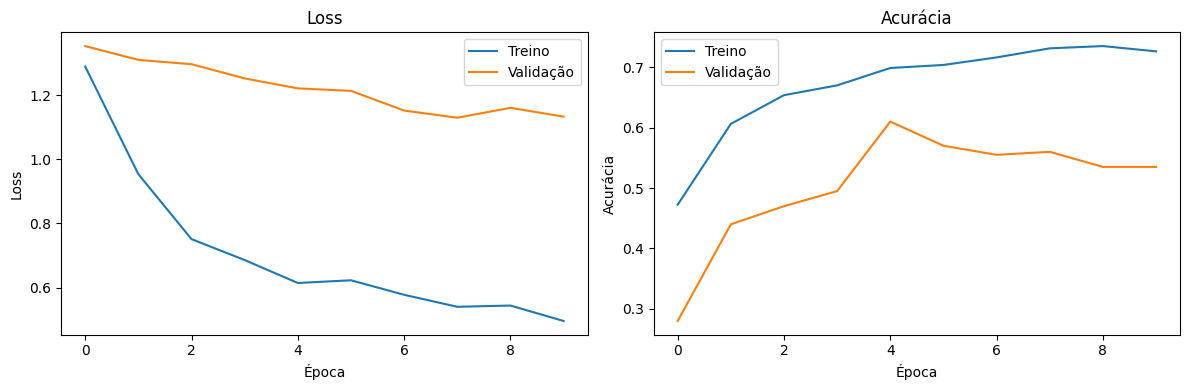

In [84]:
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treino')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Treino')
plt.plot(history_dict['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
# Fazendo predições
y_pred_probs = model.predict(X_val, verbose=0)  # Saídas do softmax
y_pred = np.argmax(y_pred_probs, axis=1)         # Pegando o índice da classe com maior probabilidade
y_true = y_val                                   # y_val já são os rótulos verdadeiros

# Relatório de classificação
print(classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_  # usa as classes corretas
))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.tight_layout()
plt.show()

NameError: name 'X_val' is not defined